# Complex Spacing Ratio

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from quantum_circuits import *
from analysis import *
from utils import *
from spectrum import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
def generate_spam_benchmark(n=3, c1=1, c2=1):
    d = 2**n

    init_target = InitialState(d, c=c1)
    povm_target = POVM(d, c=c2)

    spam_target = SPAM(init = init_target,
                       povm = povm_target)
    
    return spam_target


def generate_spam_data(spam_target, N_spam=None, shots=1024):
    n = int(np.log2(spam_target.d))
    inputs_spam, _ = generate_pauliInput_circuits(n)
    N_spam = inputs_spam.shape[0]

    state = tf.repeat(spam_target.init.init[None,:,:], N_spam, axis=0)
    targets_spam = measurement(state, U_basis = inputs_spam, povm = spam_target.povm.povm)

    #add noise
    targets_spam = add_shot_noise(targets_spam, shots = shots)
    return inputs_spam, targets_spam


def generate_map_data(channel_target, spam_target, N_map=None, shots=1024):
    n = int(np.log2(channel_target.d))
    inputs_map, _ = generate_pauli_circuits(n = n, 
                                            circuit_target=None,  
                                            trace=False,
                                            N=N_map)
    U_prep, U_basis = inputs_map

    N_map = U_prep.shape[0]
    state = tf.repeat(tf.expand_dims(spam_target.init.init, axis=0), N_map, axis=0)
    state = apply_unitary(state, U_prep)
    state = channel_target.apply_channel(state)
    targets_map = measurement(state, U_basis, spam_target.povm.povm)
    
    #add noise
    targets_map = add_shot_noise(targets_map, shots = shots)

    return inputs_map, targets_map

In [27]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list1 = []

for i in tqdm(range(1000)):
    U = circuit_to_matrix(integrable_circuit(n, 2))
    channel_target = DilutedKrausMap(U=U, c=0.7, kraus_part=KrausMap(d,rank=3))
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list1.extend(complex_spacing_ratio(spectrum))

z_list1 = np.array(z_list1)

  0%|          | 0/1000 [00:00<?, ?it/s]

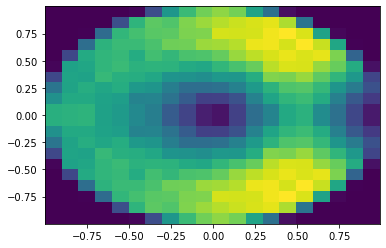

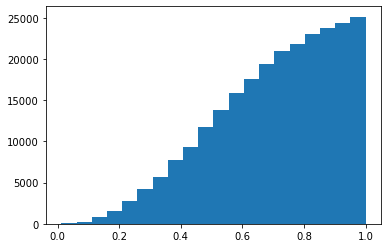

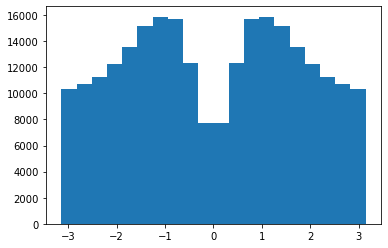

In [28]:
plt.hist2d(np.real(z_list1), np.imag(z_list1), bins=20)
plt.show()
plt.hist(np.abs(z_list1), bins=20)
plt.show()
plt.hist(np.angle(z_list1), bins=20)
plt.show()

In [29]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list2 = []

for i in tqdm(range(1000)):
    U = circuit_to_matrix(nonintegrable_circuit(n, 4))
    channel_target = DilutedKrausMap(U=U, c=0.7, kraus_part=KrausMap(d,rank=3))
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list2.extend(complex_spacing_ratio(spectrum))

z_list2 = np.array(z_list2)

  0%|          | 0/1000 [00:00<?, ?it/s]

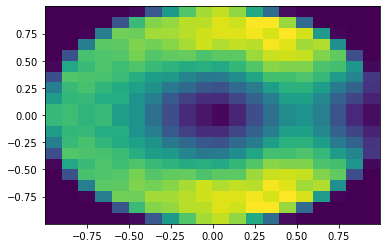

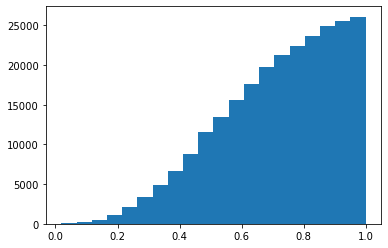

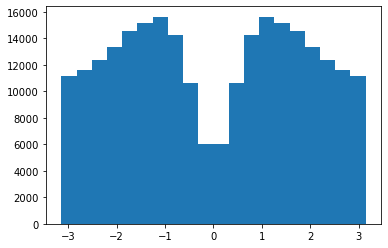

In [8]:
plt.hist2d(np.real(z_list2), np.imag(z_list2), bins=20)
plt.show()

plt.hist(np.abs(z_list2), bins=20)
plt.show()
plt.hist(np.angle(z_list2), bins=20)
plt.show()

In [30]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list3 = []

for i in tqdm(range(1000)):
    U = circuit_to_matrix(nonintegrable_circuit(n,n))
    channel_target = KrausMap(d, rank=3)
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list3.extend(complex_spacing_ratio(spectrum))

z_list3 = np.array(z_list3)

  0%|          | 0/1000 [00:00<?, ?it/s]

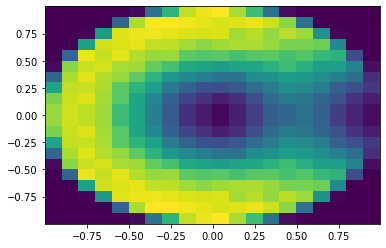

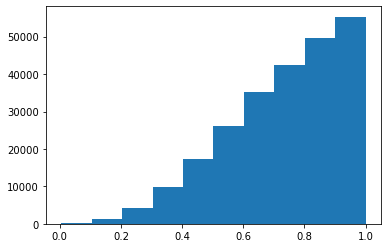

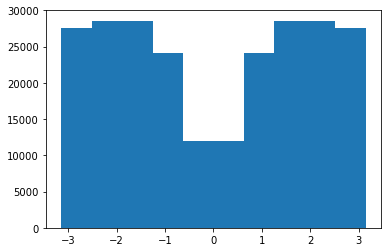

In [10]:
plt.hist2d(np.real(z_list3), np.imag(z_list3), bins=20)
plt.show()

plt.hist(np.abs(z_list3))
plt.show()
plt.hist(np.angle(z_list3))
plt.show()

     ┌──────────────┐┌────────────┐┌─────────────┐┌─────────────┐»
q_0: ┤ Rz(-0.78829) ├┤0           ├┤ Rz(-2.1613) ├┤ Rz(0.63532) ├»
     └┬────────────┬┘│  iswap^0.5 │├─────────────┤└┬────────────┤»
q_1: ─┤ Rz(2.8319) ├─┤1           ├┤ Rz(-2.1615) ├─┤0           ├»
      ├────────────┤ ├────────────┤├─────────────┤ │  iswap^0.5 │»
q_2: ─┤ Rz(1.4577) ├─┤0           ├┤ Rz(-2.7766) ├─┤1           ├»
     ┌┴────────────┤ │  iswap^0.5 │└┬────────────┤ ├────────────┤»
q_3: ┤ Rz(0.61989) ├─┤1           ├─┤ Rz(2.3008) ├─┤ Rz(2.9525) ├»
     └─────────────┘ └────────────┘ └────────────┘ └────────────┘»
«                    ┌────────────┐ ┌────────────┐              
«q_0: ───────────────┤0           ├─┤ Rz(2.0888) ├──────────────
«      ┌────────────┐│  iswap^0.5 │┌┴────────────┤┌────────────┐
«q_1: ─┤ Rz(1.3074) ├┤1           ├┤ Rz(-1.8074) ├┤0           ├
«     ┌┴────────────┤├────────────┤├─────────────┤│  iswap^0.5 │
«q_2: ┤ Rz(-3.0123) ├┤0           ├┤ Rz(-1.9992) ├┤1           ├
«     └

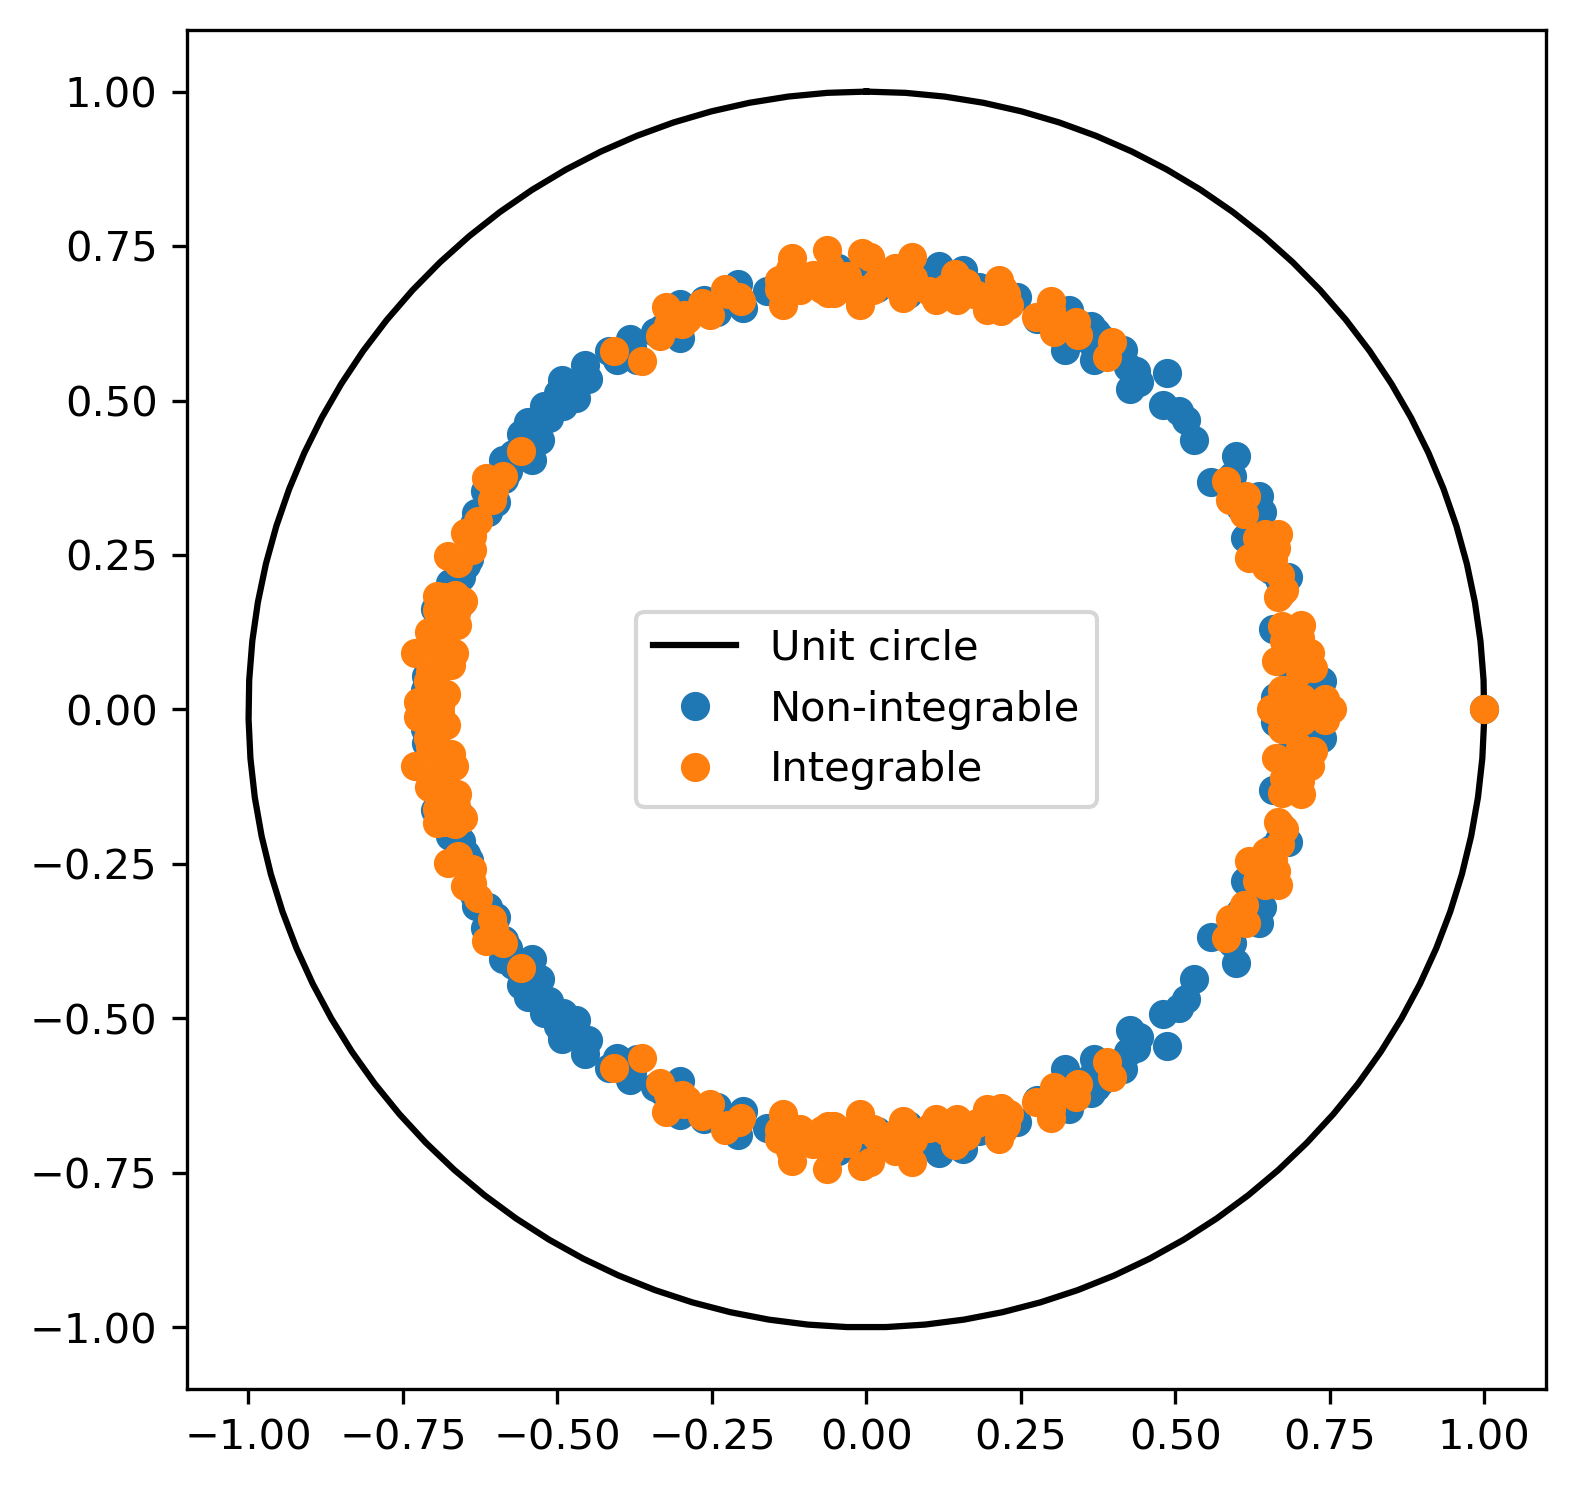

In [26]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
U_nonint = circuit_to_matrix(nonintegrable_circuit(n,2))
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
circuit_int = integrable_circuit(n,2) 
U_int = circuit_to_matrix(circuit_int)
print(circuit_int)

np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

channel_target1 = DilutedKrausMap(U=U_nonint, c=0.7, kraus_part=KrausMap(d,rank=3))
channel_target2 = DilutedKrausMap(U=U_int, c=0.7, kraus_part=KrausMap(d,rank=3))

spectrum1 = channel_spectrum(channel_target1)
spectrum2 = channel_spectrum(channel_target2)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum1[:,0], spectrum1[:,1], "o")
plt.plot(spectrum2[:,0], spectrum2[:,1], "o")
plt.legend(["Unit circle", "Non-integrable", "Integrable"])

In [4]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list4 = []

for i in tqdm(range(1000)):
    U = circuit_to_matrix(clifford_circuit(n,n))
    channel_target = KrausMap(d, rank=10)
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list4.extend(complex_spacing_ratio(spectrum))

z_list4 = np.array(z_list4)

  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\krist\Documents\ModelNISQ\notebooks\experiments\../../src_tf\spectrum.py:95: RuntimeWarning: invalid value encountered in cdouble_scalars
  z = (spectrum[idx_NN] - spectrum[i]) / (spectrum[idx_NNN] - spectrum[i])
c:\Users\krist\Documents\ModelNISQ\notebooks\experiments\../../src_tf\spectrum.py:95: RuntimeWarning: divide by zero encountered in cdouble_scalars
  z = (spectrum[idx_NN] - spectrum[i]) / (spectrum[idx_NNN] - spectrum[i])


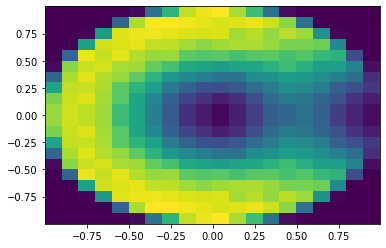

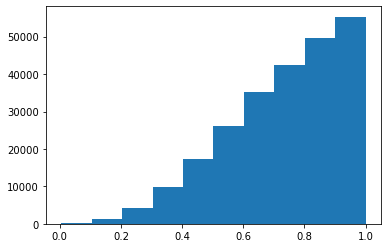

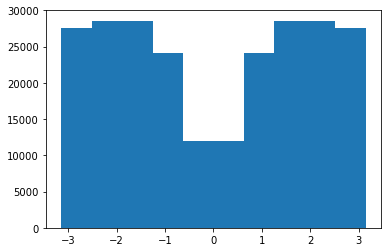

In [12]:
plt.hist2d(np.real(z_list4), np.imag(z_list4), bins=20)
plt.show()

plt.hist(np.abs(z_list4))
plt.show()
plt.hist(np.angle(z_list4))
plt.show()

## Stability of Recovered Model

In [13]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n

U = circuit_to_matrix(integrable_circuit(n,n))
channel_target = DilutedKrausMap(U=U, c=0.5, kraus_part=KrausMap(d,rank=3))

inputs_map, targets_map = generate_map_data(channel_target, IdealSPAM(d), N_map= 2000-6**n, shots=1024)

model1 = ModelQuantumMap(channel = KrausMap(d = d, 
                                            rank = d**2,
                                            ),
                        loss_function = ProbabilityMSE(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        logger = Logger(loss_function = ProbabilityMSE(),
                                        loss_function_val = channel_fidelity_loss),
                       )

model1.train(inputs = inputs_map,
            targets = targets_map,
            inputs_val = None,
            targets_val = [channel_target],
            num_iter = 2000,
            N = 500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.3279407774892944 -0.0601044431981053
0.08153021992280256 -0.3338799439917302
0.018888866461054397 -0.6653839521904774
0.009477922190564704 -0.813333764632128
0.007500250743649532 -0.8780227430372247
0.00696679396792835 -0.9110049059721864
0.006459440281337728 -0.9297073032624441
0.006201504478020777 -0.9411649996413299
0.006371849249869191 -0.9484266600716978
0.006173394441353519 -0.9530572347267351
0.0061863357103304865 -0.9566557751836794
0.005975041411738125 -0.9590091366022158
0.006395003529040787 -0.9608058241763364
0.00623717467790162 -0.9618583259172392
0.006279593422323657 -0.9627166920043554
0.006509546634252238 -0.9631431256867409
0.006080629606933145 -0.9638564453053784
0.005973671938445921 -0.9644620339597123
0.0062636057702069505 -0.9645689088824319
0.00624182740104768 -0.9647668674595072
tf.Tensor((0.005854622345756361-2.265387045238682e-19j), shape=(), dtype=complex128)
0.005964049949862125 -0.9650642805884818


In [14]:
spectrum_target = channel_spectrum(channel_target, use_coords=False, keep_real=False)
spectrum_model1 = channel_spectrum(model1.channel, use_coords=False, keep_real=False)

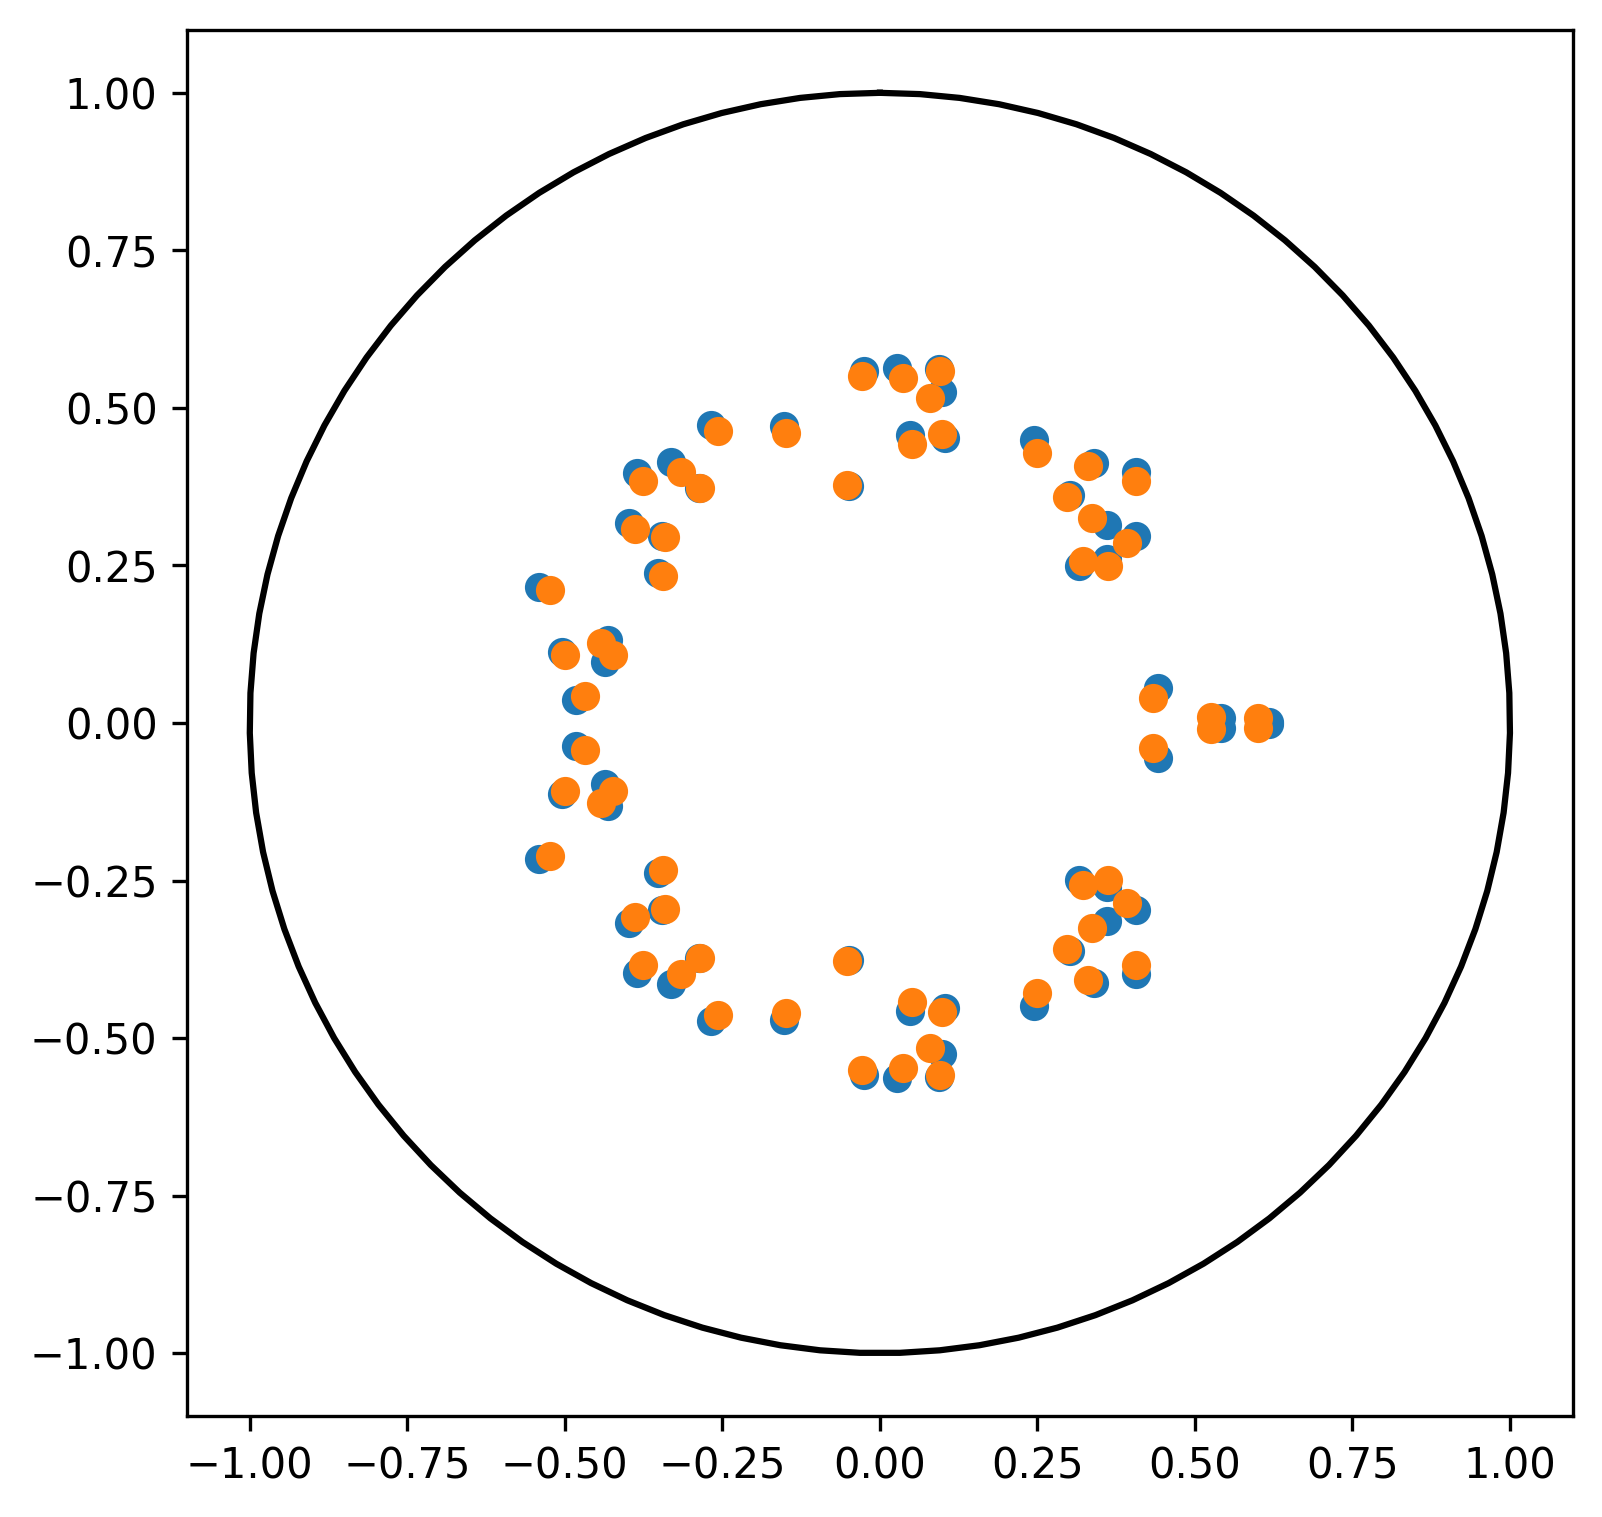

In [15]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(np.real(spectrum_target), np.imag(spectrum_target), "o")
plt.plot(np.real(spectrum_model1), np.imag(spectrum_model1), "o")

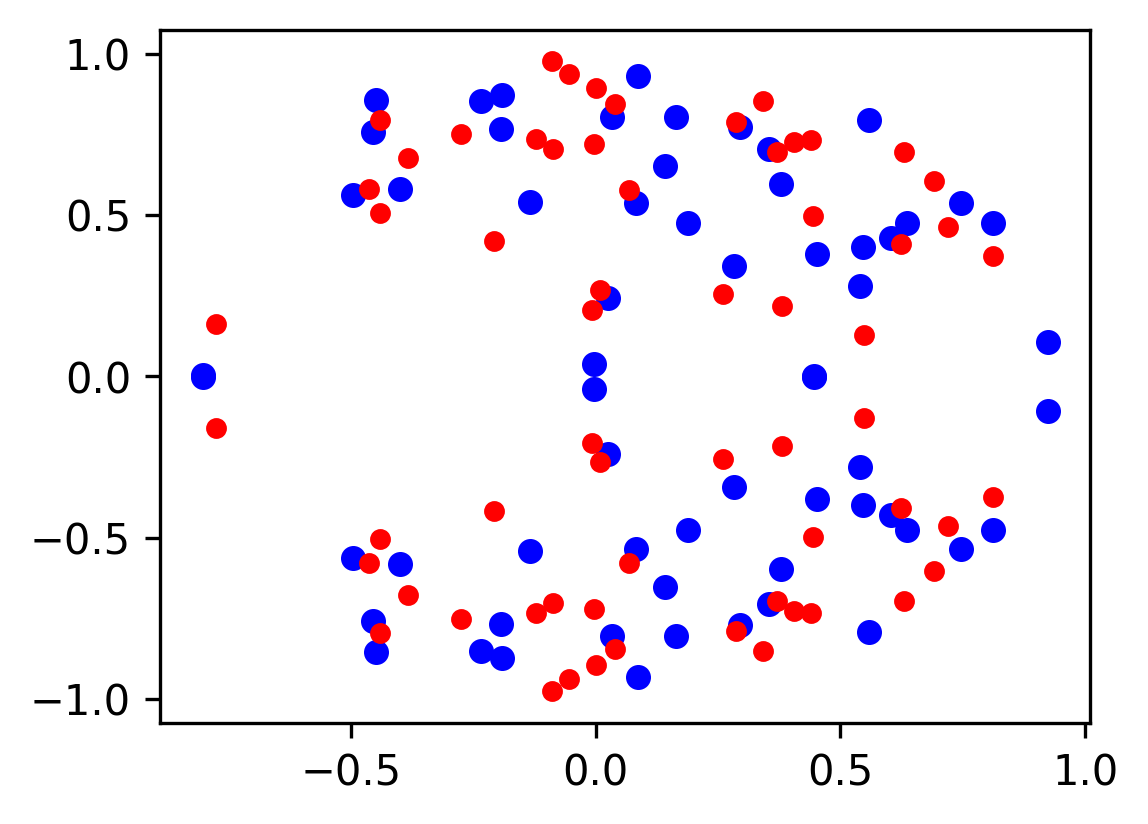

In [16]:
z_target = complex_spacing_ratio(spectrum_target)
z_model1 = complex_spacing_ratio(spectrum_model1)

fig = plt.figure(figsize=(4,3), dpi = 300, facecolor='w', edgecolor='k')

plt.plot(np.real(z_target), np.imag(z_target), 'bo', markersize=5)
plt.plot(np.real(z_model1), np.imag(z_model1), 'ro', markersize=4)
plt.show()

In [13]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n

U = circuit_to_matrix(integrable_circuit(n,n))
channel_target = DilutedKrausMap(U=U, c=0.5, kraus_part=KrausMap(d,rank=3))

inputs_map, targets_map = generate_map_data(channel_target, IdealSPAM(d), N_map= 2000-6**n, shots=1024)

model2 = ModelQuantumMap(channel = KrausMap(d = d, 
                                            rank = 4,
                                            ),
                        loss_function = ProbabilityMSE(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        logger = Logger(loss_function = ProbabilityMSE(),
                                        loss_function_val = channel_fidelity_loss),
                       )

model2.train(inputs = inputs_map,
            targets = targets_map,
            inputs_val = None,
            targets_val = [channel_target],
            num_iter = 2000,
            N = 500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.5165916162253672 -0.04473103621858283
0.18533523417897754 -0.30094521866819685
0.0694218102397083 -0.5714964542825677
0.045215388529456245 -0.7091867073309247
0.02953992739768987 -0.853082981971332
0.013857027339015185 -0.9556398361909524
0.00832407509334147 -0.9883619211673951
0.006945427432113041 -0.9963471459966949
0.006632357699306563 -0.9983581789854137
0.006530427117264879 -0.9988789407558708
0.006538404446017732 -0.9989210160718537
0.00653626852658947 -0.9989672082984735
0.006516428165269995 -0.9989534288174413
0.006533472842070549 -0.998914338130016
0.006550558442123375 -0.9988710088922853
0.0065321555120847405 -0.9989083498331163
0.006531654895487229 -0.998934875021609
0.006561183353818066 -0.9989005618326166
0.006554045507749222 -0.9988800536110434
0.006552154169857864 -0.9988808858965186
tf.Tensor((0.006590259320215944-3.8657447137179306e-19j), shape=(), dtype=complex128)
0.006549868410096083 -0.9988581506070178


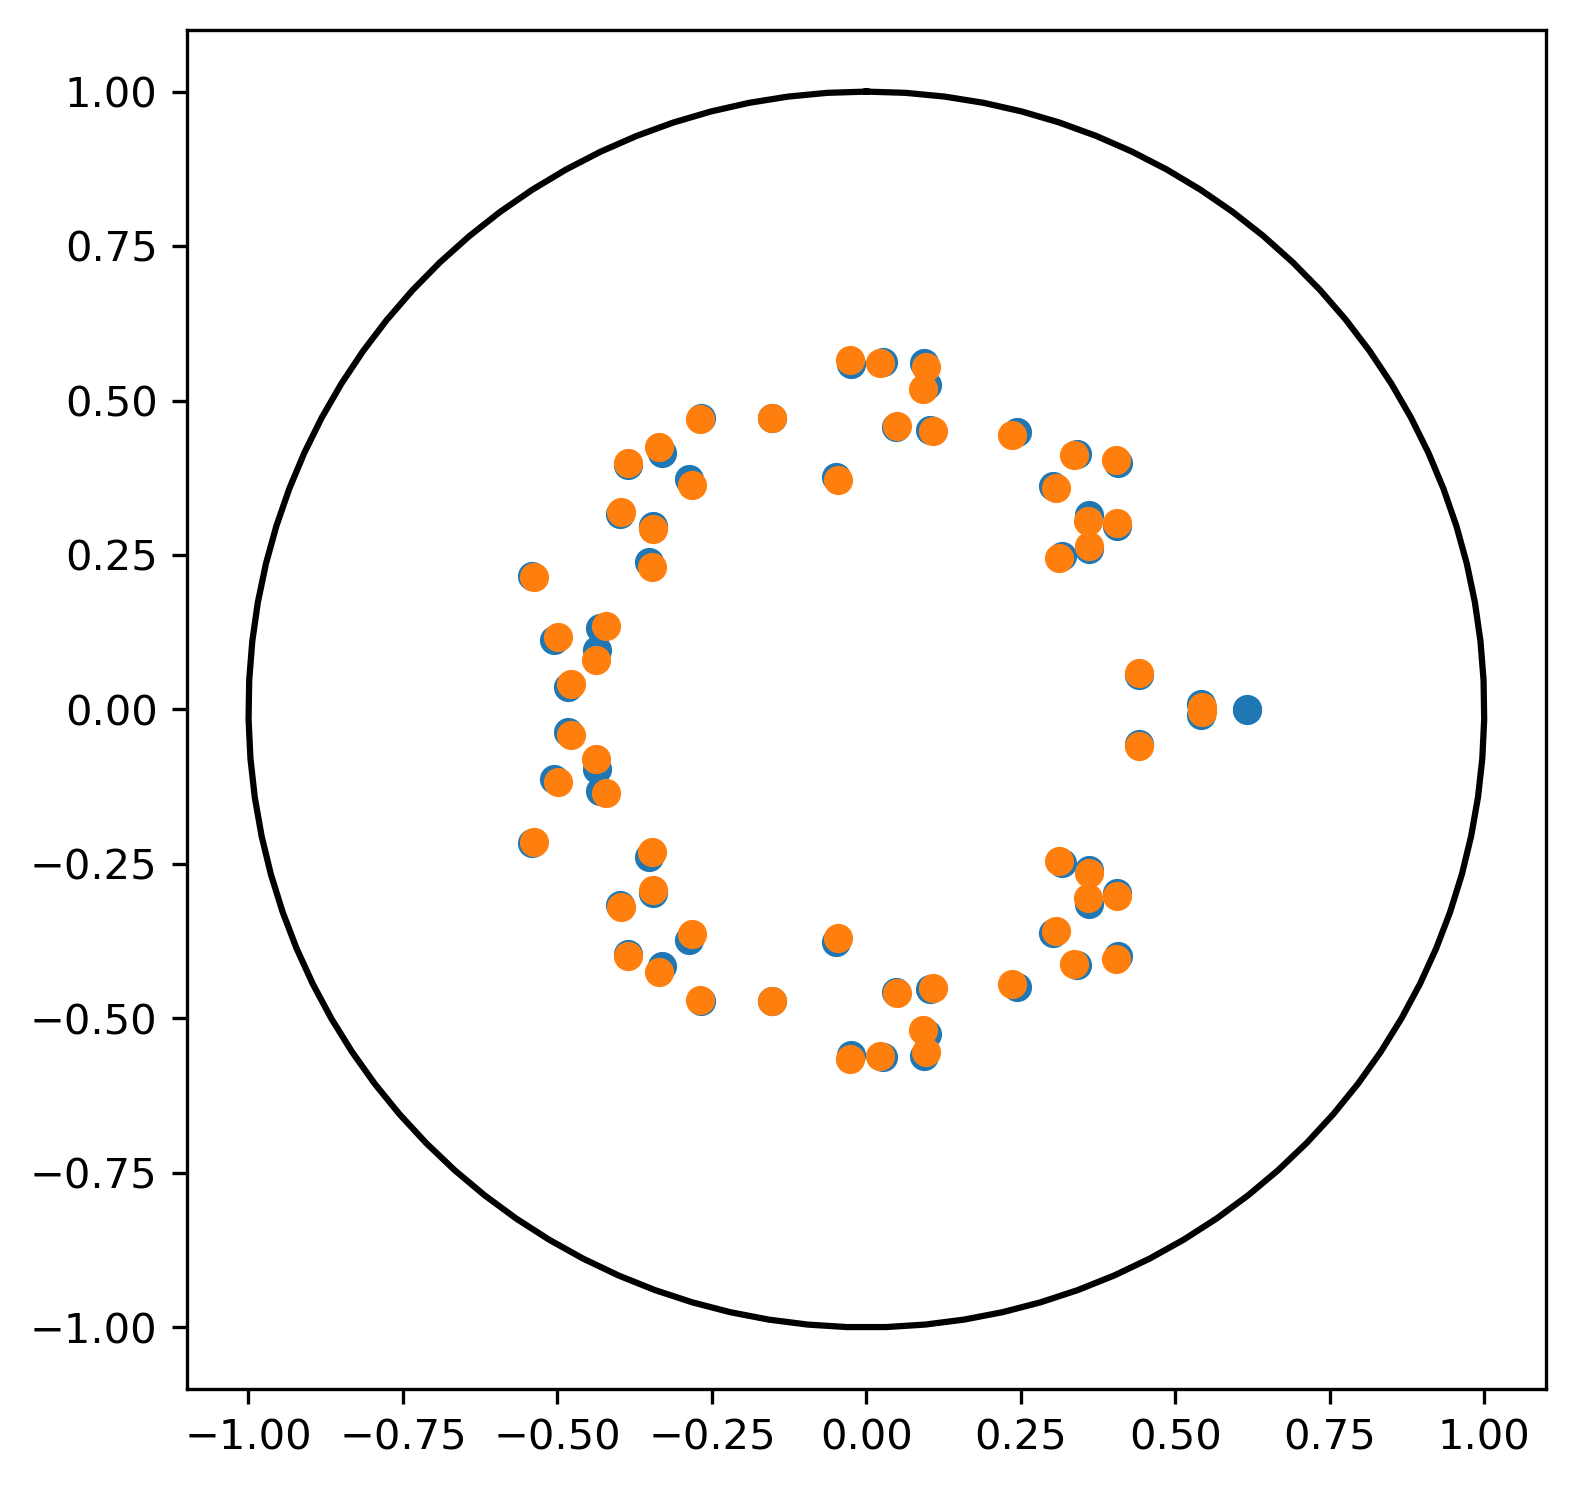

In [14]:
spectrum_target = channel_spectrum(channel_target, use_coords=False, keep_real=False)
spectrum_model2 = channel_spectrum(model2.channel, use_coords=False, keep_real=False)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(np.real(spectrum_target), np.imag(spectrum_target), "o")
plt.plot(np.real(spectrum_model2), np.imag(spectrum_model2), "o")

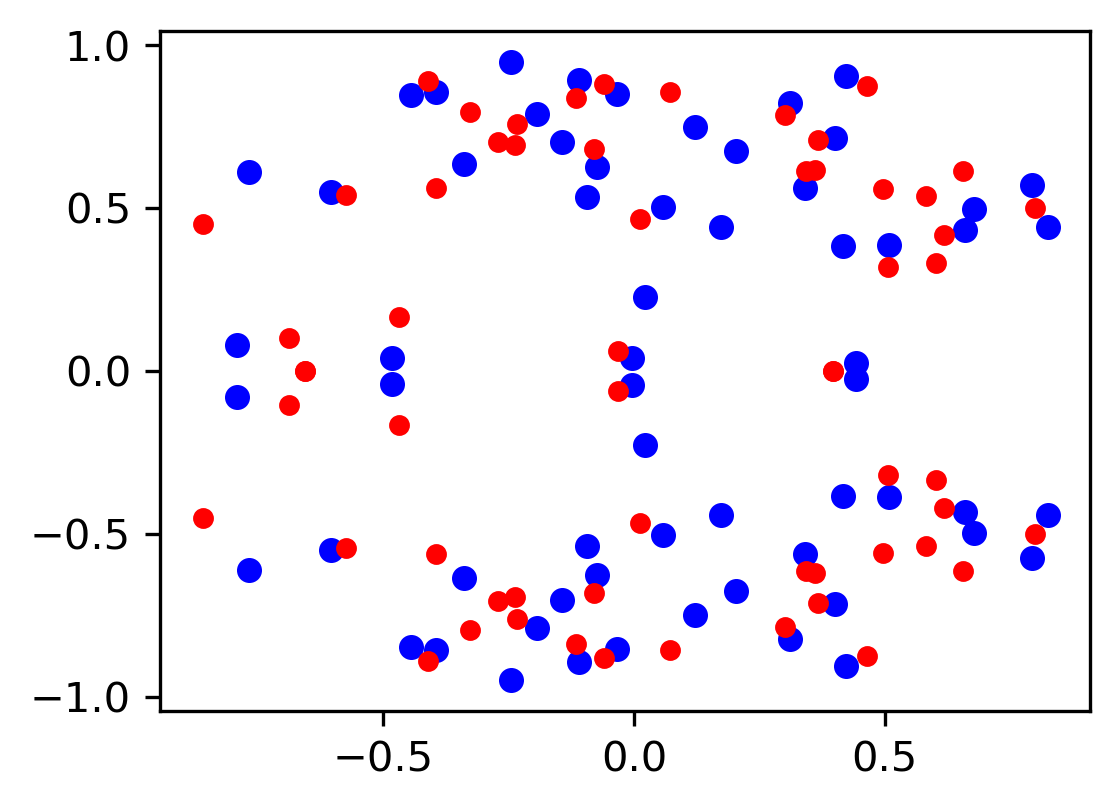

In [15]:
z_target = complex_spacing_ratio(spectrum_target)
z_model2 = complex_spacing_ratio(spectrum_model2)

fig = plt.figure(figsize=(4,3), dpi = 300, facecolor='w', edgecolor='k')

plt.plot(np.real(z_target), np.imag(z_target), 'bo', markersize=5)
plt.plot(np.real(z_model2), np.imag(z_model2), 'ro', markersize=4)
plt.show()

### Trivial Benchmark

  0%|          | 0/100 [00:00<?, ?it/s]

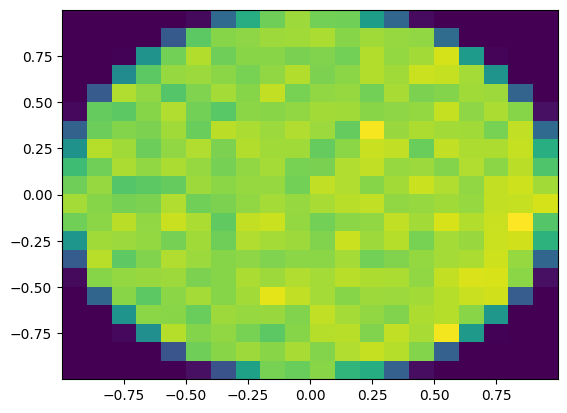

In [24]:
n = 10
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list_random = []

for i in tqdm(range(100)):
    spectrum_random = tf.complex(tf.random.normal((d,1), 0, 1), tf.random.normal((d,1), 0, 1))
    z_list_random.extend(complex_spacing_ratio(spectrum_random))

plt.hist2d(np.real(z_list_random), np.imag(z_list_random), bins=20)
plt.show()



  0%|          | 0/1000 [00:00<?, ?it/s]

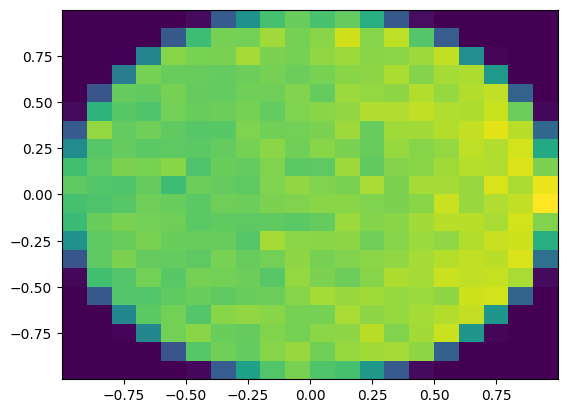

In [23]:
n = 8
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list_random = []

for i in tqdm(range(1000)):
    spectrum_random = tf.complex(tf.random.normal((d,1), 0, 1), tf.random.normal((d,1), 0, 1))
    z_list_random.extend(complex_spacing_ratio(spectrum_random))

plt.hist2d(np.real(z_list_random), np.imag(z_list_random), bins=20)
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

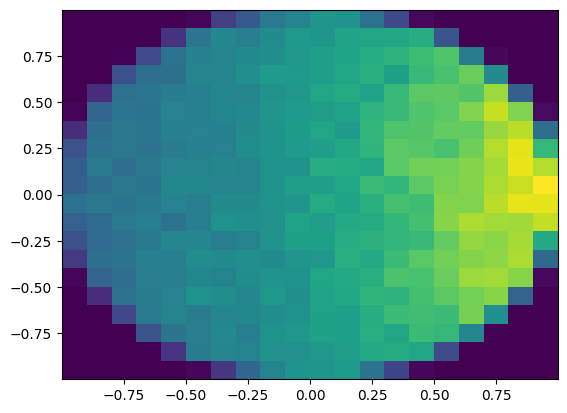

In [22]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list_random = []

for i in tqdm(range(10000)):
    spectrum_random = tf.complex(tf.random.normal((d,1), 0, 1), tf.random.normal((d,1), 0, 1))
    z_list_random.extend(complex_spacing_ratio(spectrum_random))

plt.hist2d(np.real(z_list_random), np.imag(z_list_random), bins=20)
plt.show()

### Spacing Ratio, Unitary

In [141]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list1 = []

for i in tqdm(range(200)):
    U = circuit_to_matrix(integrable_circuit(n,n))
    channel_target = ChoiMapStatic(U, mode="unitary")
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list1.extend(spacing_ratio(spectrum))

  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\krisw\AppData\Local\Temp\ipykernel_17740\2690268843.py:69: RuntimeWarning: divide by zero encountered in divide
  r = s[1:] / s[:-1]
C:\Users\krisw\AppData\Local\Temp\ipykernel_17740\2690268843.py:69: RuntimeWarning: invalid value encountered in divide
  r = s[1:] / s[:-1]
C:\Users\krisw\AppData\Local\Temp\ipykernel_17740\2690268843.py:70: RuntimeWarning: divide by zero encountered in divide
  r_tilde = np.minimum(r, 1/r)


In [142]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list2 = []

for i in tqdm(range(200)):
    U = circuit_to_matrix(nonintegrable_circuit(n,n))
    channel_target = ChoiMapStatic(U, mode="unitary")
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list2.extend(spacing_ratio(spectrum))

  0%|          | 0/200 [00:00<?, ?it/s]

In [4]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list3 = []

for i in tqdm(range(100)):
    U = circuit_to_matrix(integrable_circuit(n,n))
    channel_target = DilutedKrausMap(U=U, c=0.8, kraus_part=KrausMap(d, rank=3))
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list3.extend(complex_spacing_ratio(spectrum, real=True))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

In [6]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list4 = []

for i in tqdm(range(100)):
    U = circuit_to_matrix(nonintegrable_circuit(n,n))
    channel_target = DilutedKrausMap(U=U, c=0.8, kraus_part=KrausMap(d, rank=3))
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list4.extend(complex_spacing_ratio(spectrum, real=True))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [3]:
#plt.hist(z_list1, bins=20, density=True)
#plt.xlabel("r_tilde")
#plt.show()

#plt.hist(z_list2, bins=20, density=True)
#plt.xlabel("r_tilde")
#plt.show()


plt.hist(z_list3, bins=20, density=True)
plt.xlabel("r_tilde")
plt.show()

plt.hist(z_list4, bins=20, density=True)
plt.xlabel("r_tilde")
plt.show()

plt.plot(z_list3)
plt.show()

NameError: name 'z_list3' is not defined